# Study of Several Generative Models for Image-to-Image

In this notebook, we study several generative models (GANs and VAEs) for the task [Photo2Monet](https://www.kaggle.com/c/gan-getting-started).

In [ ]:
import tensorflow as tf
import tensorflow.experimental.numpy as tnp

import datetime, time, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


## Load data

In [ ]:
GCS_DS_PATH = 'gs://kds-0ab5e1cc018ad48110b84874a5aeee9bd352f745eff7dfed146bb0c0'

monetFilenames = tf.io.gfile.glob(GCS_DS_PATH+'/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(monetFilenames))

photoFilenames = tf.io.gfile.glob(GCS_DS_PATH+'/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(photoFilenames))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [ ]:
def decode_image(image):
  # normalizing the images to [-1, 1]
  image = tf.image.decode_jpeg(image, channels=3)
  image = (tf.cast(image, tf.float32) / 127.5) - 1
  return image

def read_tfrecord(example):
  tfrecord_format = {
      "image_name": tf.io.FixedLenFeature([], tf.string),
      "image": tf.io.FixedLenFeature([], tf.string),
      "target": tf.io.FixedLenFeature([], tf.string)
  }
  example = tf.io.parse_single_example(example, tfrecord_format)
  image = decode_image(example['image'])
  return image
    
def load_dataset(filenames):
  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
monetDs = load_dataset(monetFilenames)
photoDs = load_dataset(photoFilenames)

dataset = tf.data.Dataset.zip((photoDs.shuffle(7038), monetDs.shuffle(300).repeat(25)))
datasetMonet = tf.data.Dataset.zip((monetDs, monetDs))

for i in photoDs.take(1):
  photoValid = i

for i in monetDs.take(1):
  monetValid = i

print("Size of monetDs: ", sum(1 for record in monetDs))
print("Size of photoDs: ", sum(1 for record in photoDs))
print("Size of dataset: ", sum(1 for record in dataset))

Size of monetDs:  300
Size of photoDs:  7038
Size of dataset:  7038


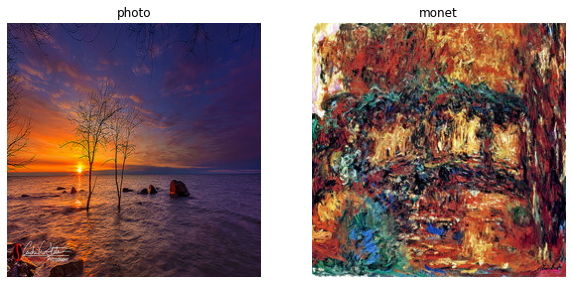

In [ ]:
def plot_images(photo, monet):
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.title('photo')
    plt.imshow(photo[:, :, :]*0.5 +0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('monet')
    plt.imshow(monet[:, :, :]*0.5 +0.5)

    plt.axis('off')
    plt.show()

for photo, monet in dataset.take(1):
  plot_images(photo, monet)

## Convolutional layers

Two sub-models for downSampling and upSamling tensor i.e., image

In [ ]:
def downSample(filters, size, applyBatchnorm=True):

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', use_bias=False))

  if applyBatchnorm:
    model.add(tf.keras.layers.BatchNormalization())


  model.add(tf.keras.layers.LeakyReLU())

  return model

def upSample(filters, size, applyDropout=False):

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())

  if applyDropout:
      model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.ReLU())

  return model

## Generative Adversarial Network

### Generator based on an [U-Net](https://arxiv.org/abs/1505.04597)

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  downStack = [
    downSample(64, 4, applyBatchnorm=False), 
    downSample(128, 4),  
    downSample(256, 4),  
    downSample(512, 4), 
    downSample(512, 4),
    downSample(512, 4),
    downSample(512, 4),
    downSample(512, 4),
    ] # (batchSize, 1, 1, 512)

  upStack = [
    upSample(512, 4, applyDropout=False),  
    upSample(512, 4, applyDropout=False),  
    upSample(512, 4, applyDropout=False),  
    upSample(512, 4),
    upSample(256, 4),
    upSample(128, 4),  
    upSample(64, 4),  
    ] # (batchSize, 128, 128, 128)

  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         activation='tanh')  # (batchSize, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in downStack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(upStack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Binary discriminator

This Discriminator returns a binary score for labeling (real or fake) images generated by the Generator.

In [ ]:
def BinaryDiscriminator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3], name='inputImage')
  targets = tf.keras.layers.Input(shape=[256, 256, 3], name='targetImage')

  downStack = [
    downSample(64, 4, applyBatchnorm=False), 
    downSample(128, 4),  
    downSample(256, 4),  
    downSample(512, 4),
    downSample(1, 4),
    ]

  x = targets

  # Downsampling through the model
  for down in downStack:
    x = down(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1)(x)

  return tf.keras.Model(inputs=[inputs, targets], outputs=x)


### Patch Discriminator based on [pix2pix](https://arxiv.org/pdf/1611.07004.pdf)

The implementation of this Discriminator is presented in [Isola et al.](https://arxiv.org/pdf/1611.07004v3.pdf). It classifies if each patch in an image is real or fake.

In [ ]:
def PatchDiscriminator():

  inputs = tf.keras.layers.Input(shape=[256, 256, 3], name='inputImage')
  targets = tf.keras.layers.Input(shape=[256, 256, 3], name='targetImage')

  x = tf.keras.layers.concatenate([inputs, targets])

  down1 = downSample(64, 4, False)(x)
  down2 = downSample(128, 4)(down1)
  down3 = downSample(256, 4)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, use_bias=False)(zero_pad1)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1)(zero_pad2)


  return tf.keras.Model(inputs=[inputs, targets], outputs=last)

### Simple [GAN](https://arxiv.org/abs/1406.2661)

In [ ]:
class GAN(tf.keras.Model):
  """Generative Adversarial Network"""

  def __init__(self, generator=None, discriminator=None):
    super(GAN, self).__init__()

    self.hyperParams = {}

    self.generator = generator
    self.discriminator = discriminator

    self.hyperParams["learningRate"] = 1e-5

    self.generatorOptimizer = tf.keras.optimizers.Adam(self.hyperParams["learningRate"])
    self.discriminatorOptimizer = tf.keras.optimizers.Adam(self.hyperParams["learningRate"])

    self.hyperParams["weightGenLoss"] = 10.
    self.hyperParams["weightDisLoss"] = 0.5
    
  # ============================================================================
  # Main functions
  # ============================================================================

  def saveHyperParameters(self, trainDirectory):
    with open(trainDirectory + "/hyperParams.txt", "w") as f:
      for param in self.hyperParams:
        f.write("%s %s \n" % (param, self.hyperParams[param]))

  def getMilestone(self):
    globalStep = self.checkpoint.globalStep.numpy()
    epochStep = globalStep // (self.hyperParams["numTraining"]//self.hyperParams["batchSize"]) 
    step = self.checkpoint.step.numpy()

    return {"globalStep": globalStep, "epochStep":epochStep, "step":step} 

  def printInfo(self, scores, forEpoch=False):
    milestone = self.getMilestone()
    outputString = ""
    if forEpoch:
      outputString += "*** EPOCH %d: " % (milestone["epochStep"])
    else:
      outputString += "--- Global Step %d Epoch %d Step %d: " % (milestone["globalStep"], milestone["epochStep"], milestone["step"])

    for scoreName in scores:
      outputString+= " %s = %.5f," % (scoreName, scores[scoreName])

    print(outputString)

  def writeSummary(self, summaries, step):
    with self.summaryWriter.as_default():
      for summaryName in summaries:
        if "Loss" in summaryName:
          tf.summary.scalar(summaryName, summaries[summaryName], step=step)
        if "Image" in summaryName:
          tf.summary.image(summaryName, summaries[summaryName], step=step, max_outputs=1)
        if "Param" in summaryName:
          hp.hparams(summaries[summaryName])

  # Dataset
  def processDataset(self, dataset):
    datasetIterator = iter(dataset.shuffle(self.hyperParams["bufferSize"], reshuffle_each_iteration=True)\
    .batch(self.hyperParams["batchSize"], drop_remainder=True).repeat(self.hyperParams["epochSize"]).prefetch(tf.data.AUTOTUNE))

    return datasetIterator

  def train(self, dataset, validSet, epochSize, batchSize, bufferSize=100, trainName="train", directory="", summaryDirectory="logs",
            fromCheckpoint=False, printInfoFreq=100, saveCheckpointFreq=2000, saveCheckpointEachEpoch=False):

    trainDirectory = "%s/%s" % (directory, trainName)
    Path(trainDirectory).mkdir(parents=True, exist_ok=True)

    # Get hyperparameters
    self.hyperParams["numTraining"] = sum(1 for _ in dataset)
    self.hyperParams["epochSize"] = epochSize
    self.hyperParams["batchSize"] = batchSize
    self.hyperParams["bufferSize"] = bufferSize

    # Summary
    summaryFileDirectory = "%s/%s/%s_%s" % (directory, summaryDirectory, trainName, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") )
    self.summaryWriter = tf.summary.create_file_writer(summaryFileDirectory)
    print("Tensorboard:", summaryFileDirectory)
    # Metrics
    self.initMetric()

    # Get dataset iterator
    datasetIterator = self.processDataset(dataset)

    # Checkpoint
    self.getCheckpoint(datasetIterator)
    self.checkpointOptions = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    self.checkpointManager = tf.train.CheckpointManager(self.checkpoint, trainDirectory+"/ckpts", max_to_keep=2)

    self.saveHyperParameters(trainDirectory)

    if fromCheckpoint and self.checkpointManager.latest_checkpoint:
      self.checkpoint.restore(self.checkpointManager.latest_checkpoint, options= self.checkpointOptions)
      print("Restored from {}".format(self.checkpointManager.latest_checkpoint))
    else:
      print("Initializing model: " + trainName)

    self.validSet = validSet
    print("START TRAINING")
    startTimeEpoch = time.time()
    for _ in range(self.checkpoint.globalStep.numpy(), self.hyperParams["epochSize"]*(self.hyperParams["numTraining"]//self.hyperParams["batchSize"]) ):
      self.checkpoint.step.assign_add(1)
      self.checkpoint.globalStep.assign_add(1)

      startTimeStep = time.time()
      infoStep = self.trainStep(next(datasetIterator))

      # Information of a step after a number of steps
      if printInfoFreq!= 0  and self.checkpoint.globalStep.numpy() % printInfoFreq == 0:
        infoStep["Duration"] = time.time() - startTimeStep
        self.printInfo(infoStep)

      # Information for an epoch
      if self.checkpoint.globalStep.numpy() % (self.hyperParams["numTraining"]//self.hyperParams["batchSize"]) == 0:
        self.epochEvaluation(duration=time.time() - startTimeEpoch)
        startTimeEpoch = time.time()
        self.checkpoint.step.assign(0)

      if saveCheckpointFreq!= 0 and (self.checkpoint.globalStep.numpy() % saveCheckpointFreq == 0 or \
      (saveCheckpointEachEpoch and (self.checkpoint.globalStep.numpy() % (self.hyperParams["numTraining"]//self.hyperParams["batchSize"]) == 0 ) ) ): 
        print("Save Checkpoint for GlobalStep %d: %s" % (self.checkpoint.globalStep.numpy(), self.checkpointManager.save(options= self.checkpointOptions)))
    
    print("Save Checkpoint for GlobalStep %d: %s" % (self.checkpoint.globalStep.numpy(), self.checkpointManager.save(options= self.checkpointOptions)))
    self.saveModel(trainDirectory)
    print("FINISHED")

  # ============================================================================
  # Custom functions
  # ============================================================================

  def getCheckpoint(self, iterator):
    self.checkpoint = tf.train.Checkpoint(globalStep=tf.Variable(0),
                                          step=tf.Variable(0),
                                          iterator=iterator,

                                          generatorOptimizer=self.generatorOptimizer,
                                          discriminatorOptimizer=self.discriminatorOptimizer,
                                          generator=self.generator,
                                          discriminator=self.discriminator
                                          )
    
  def saveModel(self, trainDirectory):
    print("Save Final model in %s" % (trainDirectory+"/model") )
    self.generator.save(trainDirectory+"/model")

  def initMetric(self):
    self.generatorEpochLoss = tf.keras.metrics.Mean(name='generatorEpochLoss')
    self.discriminatorEpochLoss = tf.keras.metrics.Mean(name='discriminatorEpochLoss')

  # Loss -----------------------------------------------------------------------
  def getGeneratorLoss(self, real, fake, fakeScore):
    crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    genLoss = tf.reduce_mean(tf.abs(real - fake))
    disLoss = crossEntropy(tf.ones_like(fakeScore), fakeScore)

    return genLoss, disLoss

  def getDiscriminatorLoss(self, real, fake):
    crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    realLoss = crossEntropy(tf.ones_like(real), real)
    fakeLoss = crossEntropy(tf.zeros_like(fake), fake)
    totalLoss = realLoss + fakeLoss

    return totalLoss

  # ----------------------------------------------------------------------------

  def epochEvaluation(self, duration=0):

    resultImage = [self.predict(self.validSet)[0]*0.5 + 0.5]
    
    self.writeSummary({"GeneratorEpochLoss": self.generatorEpochLoss.result().numpy(),
                       "DiscriminatorEpochLoss":self.discriminatorEpochLoss.result().numpy(),
                       "ResultImage":resultImage,
                       "HyperParams":self.hyperParams},
                      step=self.getMilestone()["epochStep"]
                      )
    
    self.printInfo({"GeneratorEpochLoss": self.generatorEpochLoss.result().numpy(), 
                    "DiscriminatorEpochLoss":self.discriminatorEpochLoss.result().numpy(),
                    "Duration":duration}, forEpoch=True)
    
    self.generatorEpochLoss.reset_states()
    self.discriminatorEpochLoss.reset_states()

  # ----------------------------------------------------------------------------

  @tf.function
  def trainStep(self, dataset):
    x, y = dataset
    with tf.GradientTape() as genTape, tf.GradientTape() as disTape:
      fakeY = self.generator(x, training=True)

      realYScore = self.discriminator([x, y], training=True)
      fakeYScore = self.discriminator([x, fakeY], training=True)

      genLoss, genDisLoss = self.getGeneratorLoss(y, fakeY, fakeYScore)
      disLoss = self.getDiscriminatorLoss(realYScore, fakeYScore)

      genLossAll = self.hyperParams["weightGenLoss"] * genLoss + genDisLoss
      disLossAll = self.hyperParams["weightDisLoss"] * disLoss

    gradientGenerator = genTape.gradient(genLossAll, self.generator.trainable_variables)
    gradientDiscriminator = disTape.gradient(disLossAll, self.discriminator.trainable_variables)

    self.generatorOptimizer.apply_gradients(zip(gradientGenerator, self.generator.trainable_variables))
    self.discriminatorOptimizer.apply_gradients(zip(gradientDiscriminator, self.discriminator.trainable_variables))

    self.generatorEpochLoss.update_state(genLoss + genDisLoss)
    self.discriminatorEpochLoss.update_state(disLoss)

    return {"GeneratorLoss": genLoss + genDisLoss, "DiscriminatorLoss": disLoss}

  def predict(self, input):
    return self.generator(input, training=False)


### Cycle GAN

We follow the model shown in [Zhu et al.](https://arxiv.org/abs/1703.10593)

In [ ]:
class CGAN(GAN):
  """Cycle Generative Adversarial Network"""

  def __init__(self, generator=None, discriminator=None):
    super(CGAN, self).__init__()

    self.hyperParams = {}

    self.generatorX = generator
    self.generatorY = generator

    self.discriminatorX = discriminator
    self.discriminatorY = discriminator

    self.hyperParams["learningRate"] = 1e-5

    self.generatorXOptimizer = tf.keras.optimizers.Adam(self.hyperParams["learningRate"])
    self.generatorYOptimizer = tf.keras.optimizers.Adam(self.hyperParams["learningRate"])

    self.discriminatorXOptimizer = tf.keras.optimizers.Adam(self.hyperParams["learningRate"])
    self.discriminatorYOptimizer = tf.keras.optimizers.Adam(self.hyperParams["learningRate"])

    self.hyperParams["weightGenLoss"] = 1.
    self.hyperParams["weightDisLoss"] = 0.5

    self.hyperParams["weightCycleLoss"] = 10.
    self.hyperParams["weightIndentityLoss"] = 5.

  # ============================================================================
  # Custom functions
  # ============================================================================

  def getCheckpoint(self, iterator):
    self.checkpoint = tf.train.Checkpoint(globalStep=tf.Variable(0),
                                          step=tf.Variable(0),
                                          iterator=iterator,

                                          generatorXOptimizer=self.generatorXOptimizer,
                                          generatorYOptimizer=self.generatorYOptimizer,
                                          discriminatorXOptimizer=self.discriminatorXOptimizer,
                                          discriminatorYOptimizer=self.discriminatorYOptimizer,
                                          generatorX=self.generatorX,
                                          generatorY=self.generatorY,
                                          discriminatorX=self.discriminatorX,
                                          discriminatorY=self.discriminatorY,
                                          )
    
  def saveModel(self, trainDirectory):
    print("Save Final model in %s" % (trainDirectory+"/model") )
    self.generatorY.save(trainDirectory+"/model")

  def initMetric(self):
    self.generatorYEpochLoss = tf.keras.metrics.Mean(name='generatorYEpochLoss')
    self.discriminatorYEpochLoss = tf.keras.metrics.Mean(name='discriminatorYEpochLoss')
    self.generatorXEpochLoss = tf.keras.metrics.Mean(name='generatorXEpochLoss')
    self.discriminatorXEpochLoss = tf.keras.metrics.Mean(name='discriminatorXEpochLoss')

  # Loss -----------------------------------------------------------------------
  def getGeneratorLoss(self, fakeScore):
    crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = crossEntropy(tf.ones_like(fakeScore), fakeScore)

    return loss

  def getDiscriminatorLoss(self, real, fake):
    crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    realLoss = crossEntropy(tf.ones_like(real), real)
    fakeLoss = crossEntropy(tf.zeros_like(fake), fake)
    totalLoss = realLoss + fakeLoss
    return totalLoss

  def getCycleLoss(self, real, cycle):
    loss = tf.reduce_mean(tf.abs(real - cycle))
    return loss

  def getIndentityLoss(self, real, fake):
    loss = tf.reduce_mean(tf.abs(real - fake))
    return loss
  # ----------------------------------------------------------------------------

  def epochEvaluation(self, duration=0):
    
    validInput, validOutput = self.validSet
    resultYImage = [self.generatorY(validInput, training=False)[0]*0.5 + 0.5]
    resultXImage = [self.generatorX(validOutput, training=False)[0]*0.5 + 0.5]
    
    self.writeSummary({"GeneratorEpochLoss": self.generatorYEpochLoss.result().numpy(),
                       "DiscriminatorEpochLoss":self.discriminatorYEpochLoss.result().numpy(),
                       "ResultImage":resultYImage,
                       "GeneratorEpochLoss_OppositeDirection": self.generatorXEpochLoss.result().numpy(),
                       "DiscriminatorEpochLoss_OppositeDirection":self.discriminatorXEpochLoss.result().numpy(),
                       "Image_OppositeDirection":resultXImage,
                       "HyperParams":self.hyperParams},
                      step=self.getMilestone()["epochStep"]
                      )
    
    self.printInfo({"GeneratorYEpochLoss": self.generatorYEpochLoss.result().numpy(), 
                    "DiscriminatorYEpochLoss":self.discriminatorYEpochLoss.result().numpy(),
                    "GeneratorXEpochLoss": self.generatorXEpochLoss.result().numpy(), 
                    "DiscriminatorXEpochLoss":self.discriminatorXEpochLoss.result().numpy(),
                    "Duration":duration}, forEpoch=True)
    
    self.generatorYEpochLoss.reset_states()
    self.discriminatorYEpochLoss.reset_states()

    self.generatorXEpochLoss.reset_states()
    self.discriminatorXEpochLoss.reset_states()

  # ----------------------------------------------------------------------------

  @tf.function
  def trainStep(self, dataset):
    x, y = dataset
    with tf.GradientTape(persistent=True) as tape:
      # Direction x -> fakeY
      fakeY = self.generatorY(x, training=True)
      realYScore = self.discriminatorY([x, y], training=True)
      fakeYScore = self.discriminatorY([x, fakeY], training=True)

      genYLoss = self.getGeneratorLoss(fakeYScore)
      disYLoss = self.getDiscriminatorLoss(realYScore, fakeYScore)

      # Direction y -> fakeX
      fakeX = self.generatorX(y, training=True)
      realXScore = self.discriminatorX([y, x], training=True)
      fakeXScore = self.discriminatorX([y, fakeX], training=True)

      genXLoss = self.getGeneratorLoss(fakeXScore)
      disXLoss = self.getDiscriminatorLoss(realXScore, fakeXScore)

      # Direction fakeY -> cycleX
      cycleX = self.generatorX(fakeY, training=True)
      cycleXLoss = self.getCycleLoss(x, cycleX)

      # Direction fakeX -> cycleY
      cycleY = self.generatorY(fakeX, training=True)
      cycleYLoss = self.getCycleLoss(y, cycleY)

      # Direction x -> indentityX
      indentityX = self.generatorX(x, training=True)
      indentityXLoss = self.getIndentityLoss(x, indentityX)

      # Direction y -> indentityY
      indentityY = self.generatorY(y, training=True)
      indentityYLoss = self.getIndentityLoss(y, indentityY)

      cycleLoss = cycleXLoss + cycleYLoss

      # Loss for generator
      genXAllLoss = genXLoss * self.hyperParams["weightGenLoss"] \
      + cycleLoss * self.hyperParams["weightCycleLoss"] \
      + indentityXLoss * self.hyperParams["weightIndentityLoss"]

      genYAllLoss = genYLoss * self.hyperParams["weightGenLoss"] \
      + cycleLoss * self.hyperParams["weightCycleLoss"] \
      + indentityYLoss * self.hyperParams["weightIndentityLoss"]

      # Loss for discriminator: disXLoss, disYLoss

      disXLossAll = disXLoss * self.hyperParams["weightDisLoss"]
      disYLossAll = disYLoss * self.hyperParams["weightDisLoss"]

    gradientGeneratorX = tape.gradient(genXAllLoss, self.generatorX.trainable_variables)
    gradientGeneratorY = tape.gradient(genYAllLoss, self.generatorY.trainable_variables)

    gradientDiscriminatorX = tape.gradient(disXLossAll, self.discriminatorX.trainable_variables)
    gradientDiscriminatorY = tape.gradient(disYLossAll, self.discriminatorY.trainable_variables)

    self.generatorXOptimizer.apply_gradients(zip(gradientGeneratorX, self.generatorX.trainable_variables))
    self.generatorYOptimizer.apply_gradients(zip(gradientGeneratorY, self.generatorY.trainable_variables))

    self.discriminatorXOptimizer.apply_gradients(zip(gradientDiscriminatorX, self.discriminatorX.trainable_variables))
    self.discriminatorYOptimizer.apply_gradients(zip(gradientDiscriminatorY, self.discriminatorY.trainable_variables))

    self.generatorYEpochLoss.update_state(genYLoss + cycleLoss + indentityYLoss)
    self.discriminatorYEpochLoss.update_state(disYLoss)

    self.generatorXEpochLoss.update_state(genXLoss + cycleLoss + indentityXLoss)
    self.discriminatorXEpochLoss.update_state(disXLoss)

    return {"GeneratorYLoss": genYLoss + cycleLoss + indentityYLoss, "DiscriminatorYLoss": disYLoss,
            "GeneratorXLoss": genXLoss + cycleLoss + indentityXLoss, "DiscriminatorXLoss": disXLoss}

  def predict(self, input):
    return self.generatorY(input, training=False)

## Variational Autoencoder

### Simple VAE

#### Encoder, Decoder

In [ ]:
def Encoder(latentDimension=100):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  downStack = [
    downSample(64, 4, applyBatchnorm=False), 
    downSample(128, 4),  
    downSample(256, 4),  
    downSample(512, 4), 
    downSample(512, 4),
    downSample(512, 4),
    downSample(512, 4),
    downSample(512, 4),
    ] # (batchSize, 1, 1, 512)

  x = inputs
  # Downsampling through the model
  for down in downStack:
    x = down(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(latentDimension + latentDimension, activation=None)(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

def Decoder(latentDimension=100):
  inputs = tf.keras.layers.Input(shape=[latentDimension])

  upStack = [
    upSample(512, 4, applyDropout=False),  
    upSample(512, 4, applyDropout=False),  
    upSample(512, 4, applyDropout=False), 
    upSample(512, 4),
    upSample(256, 4),
    upSample(128, 4),  
    upSample(64, 4),  
    ] # (batchSize, 128, 128, 128)

  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         activation='tanh')  # (batchSize, 256, 256, 3)

  x = tf.keras.layers.Dense(512)(inputs)
  x = tf.keras.layers.Reshape([1,1,512])(x)

  # Upsampling and establishing the skip connections
  for up in upStack:
    x = up(x)

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

#### Simple model VAE_X2Y: 2Monet

##### Model VAE_X2Y

This model is based on the original paper [Kingma et al.](https://arxiv.org/abs/1312.6114). Note that for the reconstruction term, we add the mean absolute error besides the cross-entropy.

In [ ]:
class VAE_X2Y(tf.keras.Model):
  """Variational Autoencoder"""

  def __init__(self, encoder=None, decoder=None):
    super(VAE_X2Y, self).__init__()

    self.hyperParams = {}

    self.encoder = encoder
    self.decoder = decoder

    self.hyperParams["learningRate"] = 1e-5
    self.optimizer = tf.keras.optimizers.Adam(self.hyperParams["learningRate"])

    self.hyperParams["weightGenerationLoss"] = 1.
    self.hyperParams["weightKlDivergenceLoss"] = 1.
    
  # ============================================================================
  # Main functions
  # ============================================================================

  def saveHyperParameters(self, trainDirectory):
    with open(trainDirectory + "/hyperParams.txt", "w") as f:
      for param in self.hyperParams:
        f.write("%s %s \n" % (param, self.hyperParams[param]))

  def getMilestone(self):
    globalStep = self.checkpoint.globalStep.numpy()
    epochStep = globalStep // (self.hyperParams["numTraining"]//self.hyperParams["batchSize"]) 
    step = self.checkpoint.step.numpy()

    return {"globalStep": globalStep, "epochStep":epochStep, "step":step} 

  def printInfo(self, scores, forEpoch=False):
    milestone = self.getMilestone()
    outputString = ""
    if forEpoch:
      outputString += "*** EPOCH %d: " % (milestone["epochStep"])
    else:
      outputString += "--- Global Step %d Epoch %d Step %d: " % (milestone["globalStep"], milestone["epochStep"], milestone["step"])

    for scoreName in scores:
      outputString+= " %s = %.3f," % (scoreName, scores[scoreName])

    print(outputString)

  def writeSummary(self, summaries, step):
    with self.summaryWriter.as_default():
      for summaryName in summaries:
        if "Loss" in summaryName:
          tf.summary.scalar(summaryName, summaries[summaryName], step=step)
        if "Image" in summaryName:
          tf.summary.image(summaryName, summaries[summaryName], step=step, max_outputs=1)
        if "Param" in summaryName:
          hp.hparams(summaries[summaryName])

  # Dataset
  def processDataset(self, dataset):
    datasetIterator = iter(dataset.shuffle(self.hyperParams["bufferSize"], reshuffle_each_iteration=True)\
    .batch(self.hyperParams["batchSize"], drop_remainder=True).repeat(self.hyperParams["epochSize"]).prefetch(tf.data.AUTOTUNE))

    return datasetIterator

  def train(self, dataset, validSet, epochSize, batchSize, bufferSize=100, trainName="train", directory="", summaryDirectory="logs",
            fromCheckpoint=False, printInfoFreq=100, saveCheckpointFreq=2000, saveCheckpointEachEpoch=False):

    trainDirectory = "%s/%s" % (directory, trainName)
    Path(trainDirectory).mkdir(parents=True, exist_ok=True)

    # Get hyperparameters
    self.hyperParams["numTraining"] = sum(1 for _ in dataset)
    self.hyperParams["epochSize"] = epochSize
    self.hyperParams["batchSize"] = batchSize
    self.hyperParams["bufferSize"] = bufferSize

    # Summary
    summaryFileDirectory = "%s/%s/%s_%s" % (directory, summaryDirectory, trainName, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") )
    self.summaryWriter = tf.summary.create_file_writer(summaryFileDirectory)
    print("Tensorboard:", summaryFileDirectory)
    # Metrics
    self.initMetric()

    # Get dataset iterator
    datasetIterator = self.processDataset(dataset)

    # Checkpoint
    self.getCheckpoint(datasetIterator)
    self.checkpointOptions = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    self.checkpointManager = tf.train.CheckpointManager(self.checkpoint, trainDirectory+"/ckpts", max_to_keep=2)

    self.saveHyperParameters(trainDirectory)

    if fromCheckpoint and self.checkpointManager.latest_checkpoint:
      self.checkpoint.restore(self.checkpointManager.latest_checkpoint, options= self.checkpointOptions)
      print("Restored from {}".format(self.checkpointManager.latest_checkpoint))
    else:
      print("Initializing model: " + trainName)

    self.validSet = validSet
    print("START TRAINING")
    startTimeEpoch = time.time()

    for _ in range(self.checkpoint.globalStep.numpy(), self.hyperParams["epochSize"]*(self.hyperParams["numTraining"]//self.hyperParams["batchSize"]) ):
      self.checkpoint.step.assign_add(1)
      self.checkpoint.globalStep.assign_add(1)

      startTimeStep = time.time()
      infoStep = self.trainStep(next(datasetIterator))

      # Information of a step after a number of steps
      if printInfoFreq!= 0  and self.checkpoint.globalStep.numpy() % printInfoFreq == 0:
        infoStep["Duration"] = time.time() - startTimeStep
        self.printInfo(infoStep)

      # Information for an epoch
      if self.checkpoint.globalStep.numpy() % (self.hyperParams["numTraining"]//self.hyperParams["batchSize"]) == 0:
        self.epochEvaluation(duration=time.time() - startTimeEpoch)
        startTimeEpoch = time.time()
        self.checkpoint.step.assign(0)

      if saveCheckpointFreq!= 0 and (self.checkpoint.globalStep.numpy() % saveCheckpointFreq == 0 or \
      (saveCheckpointEachEpoch and (self.checkpoint.globalStep.numpy() % (self.hyperParams["numTraining"]//self.hyperParams["batchSize"]) == 0 ) ) ): 
        print("Save Checkpoint for GlobalStep %d: %s" % (self.checkpoint.globalStep.numpy(), self.checkpointManager.save(options= self.checkpointOptions)))
    
    print("Save Checkpoint for GlobalStep %d: %s" % (self.checkpoint.globalStep.numpy(), self.checkpointManager.save(options= self.checkpointOptions)))
    self.saveModel(trainDirectory)
    print("FINISHED")

  # ============================================================================
  # Custom functions
  # ============================================================================

  def getCheckpoint(self, iterator):
    self.checkpoint = tf.train.Checkpoint(globalStep=tf.Variable(0),
                                          step=tf.Variable(0),
                                          iterator=iterator,

                                          encoder=self.encoder,
                                          decoder = self.decoder
                                          )
    
  def saveModel(self, trainDirectory):
    print("Save Final model in %s" % (trainDirectory+"/model") )
    self.encoder.save(trainDirectory+"/modelEncoder")
    self.decoder.save(trainDirectory+"/modelDecoder")
    
  def initMetric(self):
    self.generationEpochLoss = tf.keras.metrics.Mean(name='generationEpochLoss')
    self.klDivergenceEpochLoss = tf.keras.metrics.Mean(name='klDivergenceEpochLoss')

  # Loss -----------------------------------------------------------------------

  def getSample(self, x):
    mean, var = tf.split(x, num_or_size_splits=2, axis=1)
    sd = tf.math.log(1 + tf.math.exp(var))
    esp = tf.random.normal(shape=mean.shape)
    z = mean + sd * esp

    return z, mean, sd

  def getKLDivergenceLoss(self, z, mean, sd):
    klDivergenceLoss = - 0.5 * tf.reduce_sum(1 + tf.math.log(tf.math.square(sd)) - tf.math.square(mean) - tf.math.square(sd), axis=1)
    klDivergenceLoss = tf.reduce_mean(klDivergenceLoss)

    return klDivergenceLoss

  def getLoss(self, predictedY, y):
    # Note that we add MAE into the VAE loss
    crossEntropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.math.sigmoid(y), logits=predictedY)
    lossBCE = tf.reduce_mean(tf.reduce_sum(crossEntropy, axis=[1, 2, 3]) )
    lossMAE = tf.reduce_mean(tf.reduce_sum(tf.abs(y - predictedY), axis=[1, 2, 3]) )

    return lossBCE + lossMAE

  # ----------------------------------------------------------------------------
  def epochEvaluation(self, duration=0):

    resultImage = [self.predict(self.validSet)[0]*0.5 + 0.5]
    
    self.writeSummary({"GenerationEpochLoss":self.generationEpochLoss.result().numpy(),
                       "KlDivergenceEpochLoss":self.klDivergenceEpochLoss.result().numpy(),
                       "ResultImage":resultImage,
                       "HyperParams":self.hyperParams},
                      step=self.getMilestone()["epochStep"]
                      )
    
    self.printInfo({"GenerationEpochLoss":self.generationEpochLoss.result().numpy(),
                    "KlDivergenceEpochLoss":self.klDivergenceEpochLoss.result().numpy(),
                    "Duration":duration}, forEpoch=True)
    

    self.generationEpochLoss.reset_states()
    self.klDivergenceEpochLoss.reset_states()

  # ----------------------------------------------------------------------------
  
  #@tf.function
  def trainStep(self, dataset):
    x, y = dataset

    with tf.GradientTape(persistent=True) as tape:
      # Encoding
      encodedX = self.encoder(x, training=True)

      z, mean, sd = self.getSample(encodedX)

      # KL Divergence
      klDivergenceLoss = self.getKLDivergenceLoss(z, mean, sd)
      klDivergenceLossWeighted = klDivergenceLoss * self.hyperParams["weightKlDivergenceLoss"]

      # Generate Y from X
      predictedY = self.decoder(z, training=True)
      generationLoss = self.getLoss(predictedY, y)
      generationLossWeighted = generationLoss * self.hyperParams["weightGenerationLoss"]

      encoderLoss = klDivergenceLossWeighted + generationLossWeighted
      
    gradientEncoder = tape.gradient(encoderLoss, self.encoder.trainable_variables)
    gradientGenerationDecoder = tape.gradient(generationLossWeighted, self.decoder.trainable_variables)

    self.optimizer.apply_gradients(zip(gradientEncoder, self.encoder.trainable_variables))
    self.optimizer.apply_gradients(zip(gradientGenerationDecoder, self.decoder.trainable_variables))

    self.klDivergenceEpochLoss.update_state(klDivergenceLoss)
    self.generationEpochLoss.update_state(generationLoss)

    return {"GenerationLoss": generationLoss, "KLDivergenceLoss": klDivergenceLoss}

  def predict(self, x):
    encodedX = self.encoder(x, training=False)
    z, mean, sd = self.getSample(encodedX)

    y = self.decoder(z, training=False)

    return y

##### Model VAER_XY2Y_KL

We add an encoder-Monet2X and use the decoder-X2Monet to reconstruct Monet paintings, which helps the decoder to fit more the output images. Using this extra encoder-Monet2X, we obtain two latent vectors: one representing Photo and another representing Monet painting. We try to force these two distributions to be close: using KL-Divergence between these two vectors. Note that we eliminate the original KL-Divergence of VAE.

In [ ]:
class VAER_XY2Y_KL(VAE_X2Y):
  """Variational Autoencoder with reconstruction"""

  def __init__(self, encoder=None, decoder=None):
    super(VAER_XY2Y_KL, self).__init__()

    self.hyperParams = {}

    self.generationEncoder = encoder
    self.reconstructionEncoder = encoder
    self.decoder = decoder

    self.hyperParams["learningRate"] = 1e-5
    self.optimizer = tf.keras.optimizers.Adam(self.hyperParams["learningRate"])

    self.hyperParams["weightGenerationLoss"] = 1.
    self.hyperParams["weightKlDivergenceLoss"] = 1.
    self.hyperParams["weightReconstructionLoss"] = 1.

  # ============================================================================
  # Custom functions
  # ============================================================================

  def getCheckpoint(self, iterator):
    self.checkpoint = tf.train.Checkpoint(globalStep=tf.Variable(0),
                                          step=tf.Variable(0),
                                          iterator=iterator,

                                          generationEncoder=self.generationEncoder,
                                          reconstructionEncoder = self.reconstructionEncoder,
                                          decoder = self.decoder
                                          )
    
  def saveModel(self, trainDirectory):
    print("Save Final model in %s" % (trainDirectory+"/model") )
    self.generationEncoder.save(trainDirectory+"/modelEncoder")
    self.decoder.save(trainDirectory+"/modelDecoder")
    
  def initMetric(self):
    self.generationEpochLoss = tf.keras.metrics.Mean(name='generationEpochLoss')
    self.reconstructionEpochLoss = tf.keras.metrics.Mean(name='reconstructionEpochLoss')
    self.klDivergenceEpochLoss = tf.keras.metrics.Mean(name='klDivergenceEpochLoss')

  # ----------------------------------------------------------------------------
  def epochEvaluation(self, duration=0):

    resultImage = [self.predict(self.validSet)[0]*0.5 + 0.5]
    
    self.writeSummary({"GenerationEpochLoss": self.generationEpochLoss.result().numpy(),
                       "KlDivergenceEpochLoss":self.klDivergenceEpochLoss.result().numpy(),
                       "ReconstructionEpochLoss":self.reconstructionEpochLoss.result().numpy(),
                       "ResultImage":resultImage,
                       "HyperParams":self.hyperParams},
                      step=self.getMilestone()["epochStep"]
                      )
    
    self.printInfo({"GenerationEpochLoss": self.generationEpochLoss.result().numpy(),
                    "KlDivergenceEpochLoss":self.klDivergenceEpochLoss.result().numpy(),
                    "ReconstructionEpochLoss":self.reconstructionEpochLoss.result().numpy(),
                    "Duration":duration}, forEpoch=True)
    

    self.generationEpochLoss.reset_states()
    self.klDivergenceEpochLoss.reset_states()
    self.reconstructionEpochLoss.reset_states()

  # ----------------------------------------------------------------------------
  @tf.function
  def trainStep(self, dataset):
    x, y = dataset
    with tf.GradientTape(persistent=True) as tape:
      # Encoding
      encodedX = self.generationEncoder(x, training=True)
      encodedY = self.reconstructionEncoder(y, training=True)

      meanY, varY = tf.split(encodedY, num_or_size_splits=2, axis=1)
      sdY = tf.math.log(1 + tf.math.exp(varY))
      zY = meanY + sdY

      zX, meanX, sdX = self.getSample(encodedX)

      z = tf.concat([zX, zY],axis=1)

      # KL Divergence
      klDivergenceLoss = tf.keras.losses.KLDivergence()(zX, zY)
      klDivergenceLossWeighted = klDivergenceLoss * self.hyperParams["weightKlDivergenceLoss"]

      # Generate Y from X
      predictedY_X = self.decoder(z, training=True)
      generationLoss = self.getLoss(predictedY_X, y)
      generationLossWeighted = generationLoss * self.hyperParams["weightGenerationLoss"]

      # Reconstruct Y from Y
      z_ = tf.concat([zY, zY],axis=1)
      predictedY_Y = self.decoder(z_, training=False)
      reconstructionLoss = self.getLoss(predictedY_Y, y)

      # Loss
      decoderLoss = generationLossWeighted
      encoderLoss = klDivergenceLossWeighted + generationLossWeighted
      
    gradientGenerationEncoder = tape.gradient(encoderLoss, self.generationEncoder.trainable_variables)
    gradientReconstructionEncoder = tape.gradient(encoderLoss, self.reconstructionEncoder.trainable_variables)
    gradientDecoder = tape.gradient(decoderLoss, self.decoder.trainable_variables)

    self.optimizer.apply_gradients(zip(gradientGenerationEncoder, self.generationEncoder.trainable_variables))
    self.optimizer.apply_gradients(zip(gradientReconstructionEncoder, self.reconstructionEncoder.trainable_variables))
    self.optimizer.apply_gradients(zip(gradientDecoder, self.decoder.trainable_variables))

    self.klDivergenceEpochLoss.update_state(klDivergenceLoss)
    self.generationEpochLoss.update_state(generationLoss)
    self.reconstructionEpochLoss.update_state(reconstructionLoss)

    return {"GenerationLoss": generationLoss, "KLDivergenceLoss": klDivergenceLoss, "ReconstructionLoss": reconstructionLoss}

  def predict(self, inputs):
    x, y = inputs
    encodedX = self.generationEncoder(x, training=False)
    encodedY = self.reconstructionEncoder(y, training=False)

    meanY, varY = tf.split(encodedY, num_or_size_splits=2, axis=1)
    sdY = tf.math.log(1 + tf.math.exp(varY))
    zY = meanY + sdY

    zX, meanX, sdX = self.getSample(encodedX)

    z = tf.concat([zX, zY],axis=1)

    y = self.decoder(z, training=False)

    return y

### VAE with Skip connections

#### Encoder, Decoder with skip connections of U-Net

In [ ]:
def EncoderUNet(latentDimension=100):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  downStack = [
    downSample(64, 4, applyBatchnorm=False), 
    downSample(128, 4),  
    downSample(256, 4),  
    downSample(512, 4), 
    downSample(512, 4),
    downSample(512, 4),
    downSample(512, 4),
    downSample(512, 4),
    ] # (batchSize, 1, 1, 512)

  x = inputs
  # Downsampling through the model
  skips = []
  for down in downStack:
    x = down(x)
    skips.append(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(latentDimension + latentDimension, activation=None)(x)

  return tf.keras.Model(inputs=inputs, outputs=[x, skips[:-1]])

def DecoderUNet(latentDimension=100):
  inputs = tf.keras.layers.Input(shape=[latentDimension])

  skip1 = tf.keras.layers.Input(shape=[128, 128, 64])
  skip2 = tf.keras.layers.Input(shape=[64, 64, 128])
  skip3 = tf.keras.layers.Input(shape=[32, 32, 256])
  skip4 = tf.keras.layers.Input(shape=[16, 16, 512])
  skip5 = tf.keras.layers.Input(shape=[8, 8, 512])
  skip6 = tf.keras.layers.Input(shape=[4, 4, 512])
  skip7 = tf.keras.layers.Input(shape=[2, 2, 512])

  skips = [skip7, skip6, skip5, skip4, skip3, skip2, skip1]

  upStack = [
    upSample(512, 4, applyDropout=False),  
    upSample(512, 4, applyDropout=False),  
    upSample(512, 4, applyDropout=False),  
    upSample(512, 4),
    upSample(256, 4),
    upSample(128, 4),  
    upSample(64, 4),  
    ] # (batchSize, 128, 128, 128)

  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         activation='tanh')  # (batchSize, 256, 256, 3)

  x = tf.keras.layers.Dense(512)(inputs)
  x = tf.keras.layers.Reshape([1,1,512])(x)

  # Upsampling and establishing the skip connections
  for up, skip in zip(upStack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=[inputs, skip1, skip2, skip3, skip4, skip5, skip6, skip7], outputs=x)

#### Model VAE_SC_X2Y: X2Monet using Skip connections from Encoder-Photo2Monet

In [ ]:
class VAE_SC_X2Y(VAE_X2Y):
  """Variational Autoencoder using Skip connections"""

  #@tf.function
  def trainStep(self, dataset):
    x, y = dataset

    with tf.GradientTape(persistent=True) as tape:
      # Encoding
      encodedX, skips = self.encoder(x, training=True)

      z, mean, sd = self.getSample(encodedX)

      # KL Divergence
      klDivergenceLoss = self.getKLDivergenceLoss(z, mean, sd)
      klDivergenceLossWeighted = klDivergenceLoss * self.hyperParams["weightKlDivergenceLoss"]

      # Generate Y from X
      predictedY = self.decoder([z] + skips, training=True)
      generationLoss = self.getLoss(predictedY, y)
      generationLossWeighted = generationLoss * self.hyperParams["weightGenerationLoss"]

      encoderLoss = klDivergenceLossWeighted + generationLossWeighted
      
    gradientEncoder = tape.gradient(encoderLoss, self.encoder.trainable_variables)
    gradientGenerationDecoder = tape.gradient(generationLossWeighted, self.decoder.trainable_variables)

    self.optimizer.apply_gradients(zip(gradientEncoder, self.encoder.trainable_variables))
    self.optimizer.apply_gradients(zip(gradientGenerationDecoder, self.decoder.trainable_variables))

    self.klDivergenceEpochLoss.update_state(klDivergenceLoss)
    self.generationEpochLoss.update_state(generationLoss)

    return {"GenerationLoss": generationLoss, "KLDivergenceLoss": klDivergenceLoss}

  def predict(self, x):
    encodedX, skips = self.encoder(x, training=False)
    z, mean, sd = self.getSample(encodedX)

    y = self.decoder([z] + skips, training=False)

    return y

#### Model: VAE with Reconstruction components

##### Model VAER

We add an encoder-Monet2X and use the decoder-X2Monet to reconstruct Monet paintings, which helps the decoder to fit more the output paintings.

In [ ]:
class VAER(VAE_SC_X2Y):
  """Variational Autoencoder with reconstruction"""

  def __init__(self, encoder=None, decoder=None):
    super(VAER, self).__init__()

    self.hyperParams = {}

    self.generationEncoder = encoder
    self.reconstructionEncoder = encoder
    self.decoder = decoder

    self.hyperParams["learningRate"] = 1e-5
    self.optimizer = tf.keras.optimizers.Adam(self.hyperParams["learningRate"])

    self.hyperParams["weightGenerationLoss"] = 1.
    self.hyperParams["weightKlDivergenceLoss"] = 1.
    self.hyperParams["weightReconstructionLoss"] = 1.

  # ============================================================================
  # Custom functions
  # ============================================================================

  def getCheckpoint(self, iterator):
    self.checkpoint = tf.train.Checkpoint(globalStep=tf.Variable(0),
                                          step=tf.Variable(0),
                                          iterator=iterator,

                                          generationEncoder=self.generationEncoder,
                                          reconstructionEncoder = self.reconstructionEncoder,
                                          decoder = self.decoder
                                          )
    
  def saveModel(self, trainDirectory):
    print("Save Final model in %s" % (trainDirectory+"/model") )
    self.generationEncoder.save(trainDirectory+"/modelEncoder")
    self.decoder.save(trainDirectory+"/modelDecoder")
    
  def initMetric(self):
    self.generationEpochLoss = tf.keras.metrics.Mean(name='generationEpochLoss')
    self.reconstructionEpochLoss = tf.keras.metrics.Mean(name='reconstructionEpochLoss')
    self.klDivergenceEpochLoss = tf.keras.metrics.Mean(name='klDivergenceEpochLoss')

  # ----------------------------------------------------------------------------
  def epochEvaluation(self, duration=0):

    resultImage = [self.predict(self.validSet)[0]*0.5 + 0.5]
    
    self.writeSummary({"GenerationEpochLoss": self.generationEpochLoss.result().numpy(),
                       "KlDivergenceEpochLoss":self.klDivergenceEpochLoss.result().numpy(),
                       "ReconstructionEpochLoss":self.reconstructionEpochLoss.result().numpy(),
                       "ResultImage":resultImage,
                       "HyperParams":self.hyperParams},
                      step=self.getMilestone()["epochStep"]
                      )
    
    self.printInfo({"GenerationEpochLoss": self.generationEpochLoss.result().numpy(),
                    "KlDivergenceEpochLoss":self.klDivergenceEpochLoss.result().numpy(),
                    "ReconstructionEpochLoss":self.reconstructionEpochLoss.result().numpy(),
                    "Duration":duration}, forEpoch=True)
    

    self.generationEpochLoss.reset_states()
    self.klDivergenceEpochLoss.reset_states()
    self.reconstructionEpochLoss.reset_states()

  # ----------------------------------------------------------------------------
  @tf.function
  def trainStep(self, dataset):
    x, y = dataset
    with tf.GradientTape(persistent=True) as tape:
      # Encoding
      encodedX, skipsX = self.generationEncoder(x, training=True)
      encodedY, skipsY = self.reconstructionEncoder(y, training=True)

      meanY, varY = tf.split(encodedY, num_or_size_splits=2, axis=1)
      sdY = tf.math.log(1 + tf.math.exp(varY))
      zY = meanY + sdY

      zX, meanX, sdX = self.getSample(encodedX)

      # KL Divergence
      klDivergenceLoss = self.getKLDivergenceLoss(zX, meanX, sdX)
      klDivergenceLossWeighted = klDivergenceLoss * self.hyperParams["weightKlDivergenceLoss"]

      # Generate Y from X
      predictedY_X = self.decoder([zX] + skipsX, training=True)
      generationLoss = self.getLoss(predictedY_X, y)
      generationLossWeighted = generationLoss * self.hyperParams["weightGenerationLoss"]

      # Reconstruct Y from Y
      predictedY_Y = self.decoder([zY] + skipsY, training=True)
      reconstructionLoss = self.getLoss(predictedY_Y, y)
      reconstructionLossWeighted = reconstructionLoss * self.hyperParams["weightReconstructionLoss"]

      # Loss
      decoderLoss = generationLossWeighted + reconstructionLoss
      generationEncoderLoss = klDivergenceLossWeighted + generationLossWeighted
      reconstructionEncoderLoss = reconstructionLoss
      
    gradientGenerationEncoder = tape.gradient(generationEncoderLoss, self.generationEncoder.trainable_variables)
    gradientReconstructionEncoder = tape.gradient(reconstructionEncoderLoss, self.reconstructionEncoder.trainable_variables)
    gradientDecoder = tape.gradient(decoderLoss, self.decoder.trainable_variables)

    self.optimizer.apply_gradients(zip(gradientGenerationEncoder, self.generationEncoder.trainable_variables))
    self.optimizer.apply_gradients(zip(gradientReconstructionEncoder, self.reconstructionEncoder.trainable_variables))
    self.optimizer.apply_gradients(zip(gradientDecoder, self.decoder.trainable_variables))

    self.klDivergenceEpochLoss.update_state(klDivergenceLoss)
    self.generationEpochLoss.update_state(generationLoss)
    self.reconstructionEpochLoss.update_state(reconstructionLoss)

    return {"GenerationLoss": generationLoss, "KLDivergenceLoss": klDivergenceLoss, "ReconstructionLoss": reconstructionLoss}

  def predict(self, x):
    encodedX, skipsX = self.generationEncoder(x, training=False)
    zX, meanX, sdX = self.getSample(encodedX)

    y = self.decoder([zX] + skipsX, training=False)

    return y

##### Model VAER_KL

Using the extra encoder-Monet2X, we obtain two latent vectors: one representing Photo and another representing Monet painting. We try to force these two distributions to be close: using KL-Divergence between these two vectors. Note that we eliminate the original KL-Divergence of VAE.

In [ ]:
class VAER_KL(VAER):
  """Variational Autoencoder with reconstruction"""

  @tf.function
  def trainStep(self, dataset):
    x, y = dataset
    with tf.GradientTape(persistent=True) as tape:
      # Encoding
      encodedX, skipsX = self.generationEncoder(x, training=True)
      encodedY, skipsY = self.reconstructionEncoder(y, training=True)

      meanY, varY = tf.split(encodedY, num_or_size_splits=2, axis=1)
      sdY = tf.math.log(1 + tf.math.exp(varY))
      zY = meanY + sdY

      zX, meanX, sdX = self.getSample(encodedX)

      # KL Divergence
      klDivergenceLoss = tf.keras.losses.KLDivergence()(zX, zY)
      klDivergenceLossWeighted = klDivergenceLoss * self.hyperParams["weightKlDivergenceLoss"]

      # Generate Y from X
      predictedY_X = self.decoder([zX] + skipsX, training=True)
      generationLoss = self.getLoss(predictedY_X, y)
      generationLossWeighted = generationLoss * self.hyperParams["weightGenerationLoss"]

      # Reconstruct Y from Y
      predictedY_Y = self.decoder([zY] + skipsY, training=True)
      reconstructionLoss = self.getLoss(predictedY_Y, y)
      reconstructionLossWeighted = reconstructionLoss * self.hyperParams["weightReconstructionLoss"]

      # Loss
      decoderLoss = generationLossWeighted + reconstructionLoss
      generationEncoderLoss = klDivergenceLossWeighted + generationLossWeighted
      reconstructionEncoderLoss = reconstructionLoss
      
    gradientGenerationEncoder = tape.gradient(generationEncoderLoss, self.generationEncoder.trainable_variables)
    gradientReconstructionEncoder = tape.gradient(reconstructionEncoderLoss, self.reconstructionEncoder.trainable_variables)
    gradientDecoder = tape.gradient(decoderLoss, self.decoder.trainable_variables)

    self.optimizer.apply_gradients(zip(gradientGenerationEncoder, self.generationEncoder.trainable_variables))
    self.optimizer.apply_gradients(zip(gradientReconstructionEncoder, self.reconstructionEncoder.trainable_variables))
    self.optimizer.apply_gradients(zip(gradientDecoder, self.decoder.trainable_variables))

    self.klDivergenceEpochLoss.update_state(klDivergenceLoss)
    self.generationEpochLoss.update_state(generationLoss)
    self.reconstructionEpochLoss.update_state(reconstructionLoss)

    return {"GenerationLoss": generationLoss, "KLDivergenceLoss": klDivergenceLoss, "ReconstructionLoss": reconstructionLoss}

##### Model VAER_XY

We try to combine the two latent vectors generated from Encoder-Photo2 and Encoder-Monet2: summation (VAER_XY) and concatenation (VAER_CXY). Note that we still use the Kl divergence of the previous variant VAER_KL.

In [ ]:
class VAER_XY(VAER):
  """Variational Autoencoder with reconstruction component"""

  # ----------------------------------------------------------------------------
  @tf.function
  def trainStep(self, dataset):
    x, y = dataset
    with tf.GradientTape(persistent=True) as tape:
      # Encoding
      encodedX, skipsX = self.generationEncoder(x, training=True)
      encodedY, skipsY = self.reconstructionEncoder(y, training=True)

      meanY, varY = tf.split(encodedY, num_or_size_splits=2, axis=1)
      sdY = tf.math.log(1 + tf.math.exp(varY))
      zY = meanY + sdY

      zX, meanX, sdX = self.getSample(encodedX)

      z = zX + zY

      # KL Divergence
      #klDivergenceLoss = self.getKLDivergenceLoss(zY, meanY, sdY)
      klDivergenceLoss = tf.keras.losses.KLDivergence()(zX, zY)
      klDivergenceLossWeighted = klDivergenceLoss * self.hyperParams["weightKlDivergenceLoss"]

      # Generate Y from X
      predictedY_X = self.decoder([z] + skipsX, training=True)
      generationLoss = self.getLoss(predictedY_X, y)
      generationLossWeighted = generationLoss * self.hyperParams["weightGenerationLoss"]

      # Reconstruct Y from Y
      predictedY_Y = self.decoder([zY] + skipsY, training=False)
      reconstructionLoss = self.getLoss(predictedY_Y, y)

      # Loss
      decoderLoss = generationLossWeighted
      encoderLoss = klDivergenceLossWeighted + generationLossWeighted
      
    gradientGenerationEncoder = tape.gradient(encoderLoss, self.generationEncoder.trainable_variables)
    gradientReconstructionEncoder = tape.gradient(encoderLoss, self.reconstructionEncoder.trainable_variables)
    gradientDecoder = tape.gradient(decoderLoss, self.decoder.trainable_variables)

    self.optimizer.apply_gradients(zip(gradientGenerationEncoder, self.generationEncoder.trainable_variables))
    self.optimizer.apply_gradients(zip(gradientReconstructionEncoder, self.reconstructionEncoder.trainable_variables))
    self.optimizer.apply_gradients(zip(gradientDecoder, self.decoder.trainable_variables))

    self.klDivergenceEpochLoss.update_state(klDivergenceLoss)
    self.generationEpochLoss.update_state(generationLoss)
    self.reconstructionEpochLoss.update_state(reconstructionLoss)

    return {"GenerationLoss": generationLoss, "KLDivergenceLoss": klDivergenceLoss, "ReconstructionLoss": reconstructionLoss}

  def predict(self, inputs):
    x, y = inputs
    encodedX, skipsX = self.generationEncoder(x, training=False)
    encodedY, skipsY = self.reconstructionEncoder(y, training=False)

    meanY, varY = tf.split(encodedY, num_or_size_splits=2, axis=1)
    sdY = tf.math.log(1 + tf.math.exp(varY))
    zY = meanY + sdY

    zX, meanX, sdX = self.getSample(encodedX)

    z = zX + zY

    y = self.decoder([z] + skipsX, training=False)

    return y

In [ ]:
class VAER_CXY(VAER):
  """Variational Autoencoder with reconstruction component"""

  # ----------------------------------------------------------------------------
  @tf.function
  def trainStep(self, dataset):
    x, y = dataset
    with tf.GradientTape(persistent=True) as tape:
      # Encoding
      encodedX, skipsX = self.generationEncoder(x, training=True)
      encodedY, skipsY = self.reconstructionEncoder(y, training=True)

      meanY, varY = tf.split(encodedY, num_or_size_splits=2, axis=1)
      sdY = tf.math.log(1 + tf.math.exp(varY))
      zY = meanY + sdY

      zX, meanX, sdX = self.getSample(encodedX)

      z = tf.concat([zX, zY],axis=1)

      # KL Divergence
      #klDivergenceLoss = self.getKLDivergenceLoss(zY, meanY, sdY)
      klDivergenceLoss = tf.keras.losses.KLDivergence()(zX, zY)
      klDivergenceLossWeighted = klDivergenceLoss * self.hyperParams["weightKlDivergenceLoss"]

      # Generate Y from X
      predictedY_X = self.decoder([z] + skipsX, training=True)
      generationLoss = self.getLoss(predictedY_X, y)
      generationLossWeighted = generationLoss * self.hyperParams["weightGenerationLoss"]

      # Reconstruct Y from Y
      predictedY_Y = self.decoder([z] + skipsY, training=False)
      reconstructionLoss = self.getLoss(predictedY_Y, y)

      # Loss
      decoderLoss = generationLossWeighted
      encoderLoss = klDivergenceLossWeighted + generationLossWeighted
      
    gradientGenerationEncoder = tape.gradient(encoderLoss, self.generationEncoder.trainable_variables)
    gradientReconstructionEncoder = tape.gradient(encoderLoss, self.reconstructionEncoder.trainable_variables)
    gradientDecoder = tape.gradient(decoderLoss, self.decoder.trainable_variables)

    self.optimizer.apply_gradients(zip(gradientGenerationEncoder, self.generationEncoder.trainable_variables))
    self.optimizer.apply_gradients(zip(gradientReconstructionEncoder, self.reconstructionEncoder.trainable_variables))
    self.optimizer.apply_gradients(zip(gradientDecoder, self.decoder.trainable_variables))

    self.klDivergenceEpochLoss.update_state(klDivergenceLoss)
    self.generationEpochLoss.update_state(generationLoss)
    self.reconstructionEpochLoss.update_state(reconstructionLoss)

    return {"GenerationLoss": generationLoss, "KLDivergenceLoss": klDivergenceLoss, "ReconstructionLoss": reconstructionLoss}

  def predict(self, inputs):
    x, y = inputs
    encodedX, skipsX = self.generationEncoder(x, training=False)
    encodedY, skipsY = self.reconstructionEncoder(y, training=False)

    meanY, varY = tf.split(encodedY, num_or_size_splits=2, axis=1)
    sdY = tf.math.log(1 + tf.math.exp(varY))
    zY = meanY + sdY

    zX, meanX, sdX = self.getSample(encodedX)

    z = tf.concat([zX, zY],axis=1)

    y = self.decoder([z] + skipsX, training=False)

    return y

## Train

We train all models for 20 iterations (we can obtain better results if we train more these models). Learning rate is 1e-5. For other hyperparameters, we use their default values. Note that we add different weights into loss for GANs. 

### Train GAN

In [ ]:
with tf.device('/device:GPU:0'):
  simpleGan = GAN(Generator(), BinaryDiscriminator())
    
simpleGan.train(dataset, validSet = tnp.array([photoValid]), epochSize=20, batchSize=20, directory=directory, trainName="simpleGanBinaryDiscriminator")

In [ ]:
with tf.device('/device:GPU:0'):
  patchGan = GAN(Generator(), PatchDiscriminator())
    
patchGan.train(dataset, validSet = tnp.array([photoValid]), epochSize=20, batchSize=20, directory=directory, trainName="ganPatchDiscriminator")

In [ ]:
with tf.device('/device:GPU:0'):
  cycleGanB = CGAN(Generator(), BinaryDiscriminator())

cycleGanB.train(dataset, validSet = (tnp.array([photoValid]), tnp.array([monetValid])), epochSize=20, batchSize=20, directory=directory, trainName="cycleGanBinaryDiscriminator")

In [ ]:
with tf.device('/device:GPU:0'):
  cycleGanP = CGAN(Generator(), PatchDiscriminator())

cycleGanP.train(dataset, validSet = (tnp.array([photoValid]), tnp.array([monetValid])), epochSize=20, batchSize=20, directory=directory, trainName="cycleGanPatchDiscriminator")

### Train VAE

#### Train simple VAE_XY

##### Simple model: vaeP2M (Photo2Monet) and vaeM2M (Monet2Monet)

In [ ]:
with tf.device('/device:GPU:0'):
  vaeP2M = VAE_X2Y(Encoder(100), Decoder(100))

  vaeP2M.hyperParams["weightGenerationLoss"] = 1.
  vaeP2M.hyperParams["weightKlDivergenceLoss"] = 1.

vaeP2M.train(dataset, validSet = tnp.array([photoValid]), epochSize=20, batchSize=20, directory=directory, printInfoFreq=0, saveCheckpointFreq=0, trainName="vaeP2M")

In [ ]:
with tf.device('/device:GPU:0'):
  vaeM2M = VAE_X2Y(Encoder(100), Decoder(100))

  vaeM2M.hyperParams["weightGenerationLoss"] = 1.
  vaeM2M.hyperParams["weightKlDivergenceLoss"] = 1.

vaeM2M.train(datasetMonet, validSet = tnp.array([monetValid]), epochSize=20, batchSize=20, directory=directory, printInfoFreq=0, saveCheckpointFreq=0, trainName="vaeM2M")

In [ ]:
with tf.device('/device:GPU:0'):
  vaeM2M_200 = VAE_X2Y(Encoder(100), Decoder(100))

  vaeM2M_200.hyperParams["weightGenerationLoss"] = 1.
  vaeM2M_200.hyperParams["weightKlDivergenceLoss"] = 1.

vaeM2M_200.train(datasetMonet, validSet = tnp.array([monetValid]), epochSize=200, batchSize=20, directory=directory, printInfoFreq=0, saveCheckpointFreq=0, trainName="vaeM2M_200")

##### Model VAER_XY2Y

In [ ]:
with tf.device('/device:GPU:0'):
  vaeR_XY2Y_KL = VAER_XY2Y_KL(Encoder(100), Decoder(200))

  vaeR_XY2Y_KL.hyperParams["weightGenerationLoss"] = 1.
  vaeR_XY2Y_KL.hyperParams["weightKlDivergenceLoss"] = 1.

vaeR_XY2Y_KL.train(dataset, validSet = (tnp.array([photoValid]), tnp.array([monetValid])), epochSize=20, batchSize=20, directory=directory, printInfoFreq=0, saveCheckpointFreq=0, trainName="vaeR_XY2Y_KL")

#### Train VAE_SC_X2Y with Skip connections: Photo2Monet

In [ ]:
with tf.device('/device:GPU:0'):
  vaeScP2M = VAE_SC_X2Y(EncoderUNet(100), DecoderUNet(100))

  vaeScP2M.hyperParams["weightGenerationLoss"] = 100.
  vaeScP2M.hyperParams["weightKlDivergenceLoss"] = 1.

vaeScP2M.train(dataset, validSet = tnp.array([photoValid]), epochSize=20, batchSize=20, directory=directory, printInfoFreq=0, saveCheckpointFreq=0, trainName="vaeScP2M")

##### Train VAER with recontruction components

In [ ]:
with tf.device('/device:GPU:0'):
  vaeR = VAER(EncoderUNet(100), DecoderUNet(100))

  vaeR.hyperParams["weightGenerationLoss"] = 1.
  vaeR.hyperParams["weightKlDivergenceLoss"] = 1.
  vaeR.hyperParams["weightReconstructionLoss"] = 1.

vaeR.train(dataset, validSet = tnp.array([photoValid]), epochSize=20, batchSize=20, directory=directory, printInfoFreq=0, saveCheckpointFreq=0, trainName="vaeR")

In [ ]:
with tf.device('/device:GPU:0'):
  vaeR_KL = VAER_KL(EncoderUNet(100), DecoderUNet(100))

  vaeR_KL.hyperParams["weightGenerationLoss"] = 1.
  vaeR_KL.hyperParams["weightKlDivergenceLoss"] = 1.
  vaeR_KL.hyperParams["weightReconstructionLoss"] = 1.

vaeR_KL.train(dataset, validSet = tnp.array([photoValid]), epochSize=20, batchSize=20, directory=directory, printInfoFreq=0, saveCheckpointFreq=0, trainName="vaeR_KL")

In [ ]:
with tf.device('/device:GPU:0'):
  vaeR_XY = VAER_XY(EncoderUNet(100), DecoderUNet(100))

  vaeR_XY.hyperParams["weightGenerationLoss"] = 1.
  vaeR_XY.hyperParams["weightKlDivergenceLoss"] = 1.

vaeR_XY.train(dataset, validSet = (tnp.array([photoValid]), tnp.array([monetValid])), epochSize=20, batchSize=20, directory=directory, printInfoFreq=0, saveCheckpointFreq=0, trainName="vaeR_XY")

In [ ]:
with tf.device('/device:GPU:0'):
  vaeR_CXY = VAER_CXY(EncoderUNet(100), DecoderUNet(200))

  vaeR_CXY.hyperParams["weightGenerationLoss"] = 1.
  vaeR_CXY.hyperParams["weightKlDivergenceLoss"] = 1.

vaeR_CXY.train(dataset, validSet = (tnp.array([photoValid]), tnp.array([monetValid])), epochSize=20, batchSize=20, directory=directory, printInfoFreq=0, saveCheckpointFreq=0, trainName="vaeR_CXY")

## Discussion 

In [ ]:
def showResultGAN(photo, models, title, figsize=(20,5)):
  numModel = len(models)
  fig, axs = plt.subplots(1, numModel+1, figsize=figsize)
  fig.suptitle(title)

  axs[0].set_title('Photo')
  axs[0].imshow(photo[:, :, :]*0.5 +0.5)
  axs[0].axis('off')

  for idx, model in enumerate(models):
    axs[idx+1].set_title(model)
    loadedModel = tf.keras.models.load_model(models[model], compile=False)
    axs[idx+1].imshow(loadedModel(np.array([photo]))[0]*0.5 +0.5)
    axs[idx+1].axis('off')
    
def sampling(encoder, decoder, photo, onlyNoise=False, noNoise=False, useSkip=False, concat=False, sum=False):
  if useSkip:
    x, skips = encoder(np.array([photo]))
    mean, var = tf.split(x, num_or_size_splits=2, axis=1)
    sd = tf.math.log(1 + tf.math.exp(var))
    esp = tf.random.normal(shape=mean.shape)

    z = mean + sd * esp
    if onlyNoise:
      z = esp
    if noNoise:
      z = mean + sd
    if concat:
      z = tf.concat([z, z],axis=1)
    if sum:
      z = z + z

    y = decoder([z]+skips)
    return y

  else:
    x = encoder(np.array([photo]))
    mean, var = tf.split(x, num_or_size_splits=2, axis=1)
    sd = tf.math.log(1 + tf.math.exp(var))
    esp = tf.random.normal(shape=mean.shape)
    z = mean + sd * esp
    if onlyNoise:
      z = esp
    if noNoise:
      z = mean + sd
    if concat:
      z = tf.concat([z, z],axis=1)
    if sum:
      z = z + z

    y = decoder(z)
    return y

def showResultVAE(photo, models, title, figsize=(20,5), binary=False, 
                  onlyNoise=False, noNoise=False, useSkips=None, concats=None, sums=None):
  numModel = len(models)
  fig, axs = plt.subplots(1, numModel+1, figsize=figsize)
  fig.suptitle(title)

  if onlyNoise:
    photo = np.ones(np.shape(photo))

  axs[0].set_title('Photo')
  axs[0].imshow(photo[:, :, :]*0.5 +0.5)
  axs[0].axis('off')

  for idx, (model, useSkip, concat, sum) in enumerate(zip(models, useSkips, concats, sums)):
    axs[idx+1].set_title(model)
    loadedEncoder = tf.keras.models.load_model(models[model][0], compile=False)
    loadedDecoder = tf.keras.models.load_model(models[model][1], compile=False)

    y = sampling(loadedEncoder, loadedDecoder, photo, 
                 onlyNoise=onlyNoise, noNoise=noNoise,
                 useSkip=useSkip, concat=concat, sum=sum)
  
    outImage = (y[0].numpy()*0.5 + 0.5)
    if binary:
      outImage = np.where(outImage >= 0.5, 1, outImage)
      outImage = np.where(outImage < 0.5, 0, outImage)

    axs[idx+1].imshow(outImage)
    axs[idx+1].axis('off')


### GANs

The next cell displays the images generated by GANs: a shallow [GAN](https://arxiv.org/abs/1406.2661) and a much more complex GAN ([Cycle GAN](https://arxiv.org/abs/1703.10593)). We use a Generator based on U-Net and two different discriminators (Binary and Patch Discriminator). Training losses of these models are found in [Tensorboard](https://tensorboard.dev/experiment/A7VGgbaNQLaGg37hx5xv7g/).

In general, the images generated by GAN with Binary Discriminator and CycleGan with Patch Discriminator seem to be the best results. 

We also observe that the shallow GAN breaks mostly the structure of the original photo by using Patch Discriminator. Note that we can see easily the generated patchs in the output image. For CycleGan with Binary discriminator, it fails to generate Monet style: the result is too similar to the original image.

In the case of shallow GANs, the loss of the Binary Discriminator reduces faster than the Patch Discriminator, leading to a large loss of the Generator. This means that the Patch Discriminator produces a more stable training.

We compare the two result images when using Patch Discriminator. Cycle GANs can help to preserve the main details (the right image), which implies the better Generator.

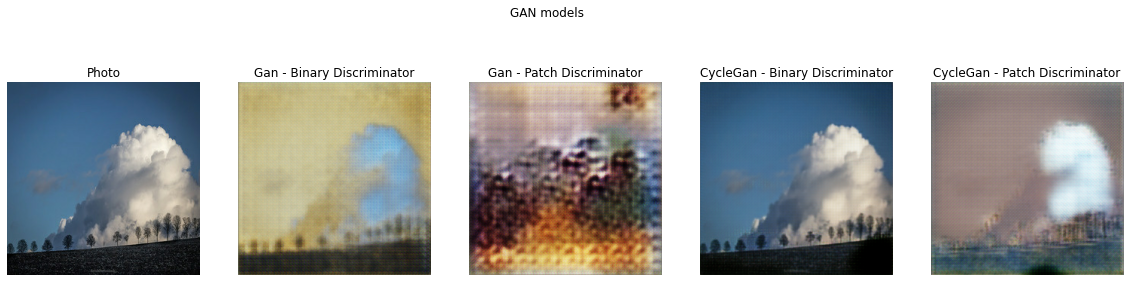

In [ ]:
GANmodels = {"Gan - Binary Discriminator":"/content/drive/MyDrive/Colab Notebooks/GenerativeModels/GAN_Models/simpleGanBinaryDiscriminator/model", 
             "Gan - Patch Discriminator": "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/GAN_Models/ganPatchDiscriminator/model", 
             "CycleGan - Binary Discriminator":"/content/drive/MyDrive/Colab Notebooks/GenerativeModels/GAN_Models/cycleGanBinaryDiscriminator/model", 
             "CycleGan - Patch Discriminator":"/content/drive/MyDrive/Colab Notebooks/GenerativeModels/GAN_Models/cycleGanPatchDiscriminator/model" }
            

showResultGAN(photoValid, GANmodels, "GAN models")

### VAEs

The training procedure of the VAEs are stored in [Tensorboard](https://tensorboard.dev/experiment/ClwoxJ7LQa6gDgmwi7NkRw/).

#### Simple VAEs

The result images of two shallow VAEs (Photo2Monet and Monet2Monet) after 20 iterations are displayed in the next cell. Compared with GANs, we can see that these images are more blurred, which means that the models are still underfitting after 20 iterations. This is because our VAEs are simpler than GANs. Note that in the case of Photo2Monet, KL divergence largely drops whereas an opposite pattern is found in Monet2Monet (this is simply because this reconstruction is easier to learn).

Modifying weights of losses does not help to reduce training time and losses of these models (see HParams of vaeM2M_WeightsKL_1 and vaeM2M_WeightsKL_2 saved in [Tensorboard](https://tensorboard.dev/experiment/ClwoxJ7LQa6gDgmwi7NkRw/))

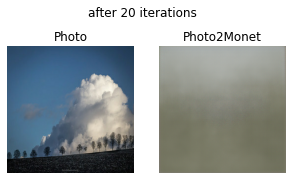

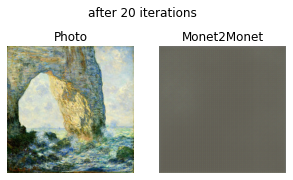

In [ ]:
VAE_P2M = {"Photo2Monet":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeP2M/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeP2M/modelDecoder"]}
VAE_M2M = {"Monet2Monet":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeM2M/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeM2M/modelDecoder"]}
             
showResultVAE(photoValid, VAE_P2M, "after 20 iterations", figsize=(5,3), useSkips=[False, False], concats=[False, False], sums=[False, False])
showResultVAE(monetValid, VAE_M2M, "after 20 iterations", figsize=(5,3), useSkips=[False, False], concats=[False, False], sums=[False, False])

We now observe several images generated by Monet2Monet model after 200 iterations with different inputs. For this traning, we only use the monet dataset which includes 300 monet painting. We can see all changes of output images for each update collected in VAE_Logs/vaeM2M_200Iterations by using Tensorboard.

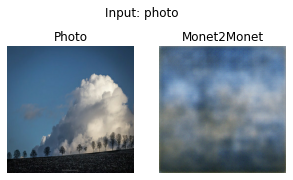

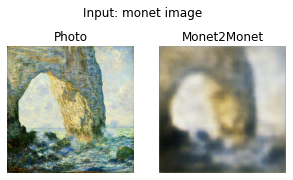

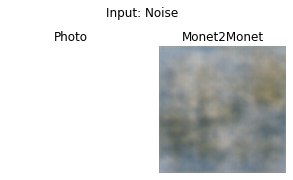

In [ ]:
VAE_M2M = {"Monet2Monet":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeM2M_200/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeM2M_200/modelDecoder"]}

showResultVAE(photoValid, VAE_M2M, "Input: photo", figsize=(5,3), useSkips=[False], concats=[False], sums=[False])
showResultVAE(monetValid, VAE_M2M, "Input: monet image", figsize=(5,3), useSkips=[False], concats=[False], sums=[False])
showResultVAE(photoValid, VAE_M2M, "Input: Noise", figsize=(5,3), onlyNoise=True, useSkips=[False], concats=[False], sums=[False])


##### VAEs using Skip connections

Since the images are blurred (set binary=False), we do not see an improvement of skip connections in this case (for 20 iterations). An explaination for this is that the model still need more training iterations (e.g., 200 iterations)

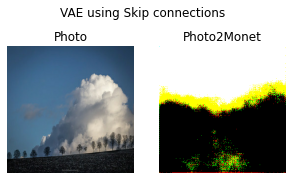

In [ ]:
VAE_SC_P2M = {"Photo2Monet":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeScP2M/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeScP2M/modelDecoder"]}

showResultVAE(photoValid, VAE_SC_P2M, "VAE using Skip connections", figsize=(5,3), useSkips=[True], concats=[False], sum=[False],
              binary=True)

#### VAEs with Reconstruction components

We observe results generated by several variants (using skip connections) [VAER](https://colab.research.google.com/drive/1x1oYuzAeRCk2Irm-s2ym_VHIJpS1Z2BG#scrollTo=cvTRF-ZA4_5I), [VAER_KL](https://colab.research.google.com/drive/1x1oYuzAeRCk2Irm-s2ym_VHIJpS1Z2BG#scrollTo=dLJpxas17bcx), [VAER_XY](https://colab.research.google.com/drive/1x1oYuzAeRCk2Irm-s2ym_VHIJpS1Z2BG#scrollTo=u5x-V2yxfq5N&line=1&uniqifier=1) and [VAER_CXY](https://colab.research.google.com/drive/1x1oYuzAeRCk2Irm-s2ym_VHIJpS1Z2BG#scrollTo=u5x-V2yxfq5N&line=1&uniqifier=1).

For these models, we add an extra encoder for monet paintings in addition to the photo encoder. This means that we have two latent vectors, one for photo and one for monet painting. In the case of VAER, we add a loss for reconstruction of monet paintings. For VAER_KL model, KL divergence is used to penalize distance between the photo vector and the monet painting vector instead of Gaussian distribution. The final variant is to combine these two vectors by summation (VAER_XY) and concatenation (VAER_CXY). 

For this analysis, we only rely on photo (i.e., concatenating two embedding vectors of photo input).

In the training process (see [Tensorboard](https://tensorboard.dev/experiment/ClwoxJ7LQa6gDgmwi7NkRw/)), compared with [Monet2Monet](https://colab.research.google.com/drive/1x1oYuzAeRCk2Irm-s2ym_VHIJpS1Z2BG#scrollTo=7iekr0JO0B_8&line=1&uniqifier=1) (using 200 iterations), the models with reconstruction component obtains the smaller losses. We can gain a better performance if we concatenate the two vectors.

As can be seen in the two first images generated by VAER and VAER_KL, it is not surprising that using skip connections of the original photo creates a strong impact and only several green zones are from the latent variable z (added noises). Combining the two vectors clearly helps to enforce the latent variable z (i.e., more blurred image)

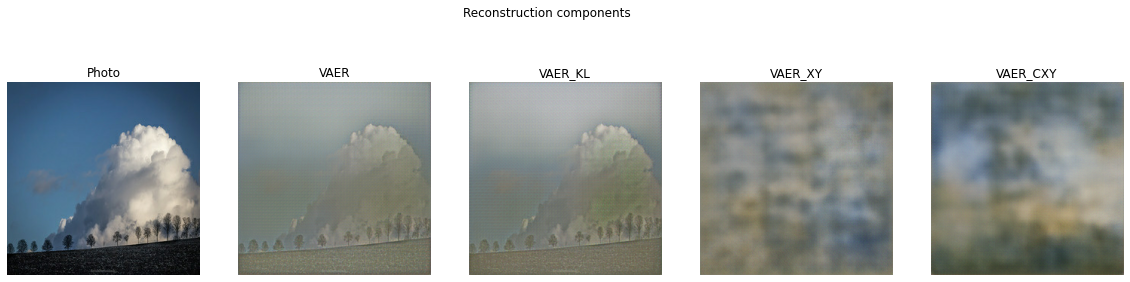

In [ ]:
VAE_R = {"VAER":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR/modelDecoder"],
         "VAER_KL":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_KL/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_KL/modelDecoder"],
         "VAER_XY":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_XY/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_XY/modelDecoder"],
         "VAER_CXY":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_CXY/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_CXY/modelDecoder"],
          }

showResultVAE(photoValid, VAE_R, "Reconstruction components", figsize=(20,5), useSkips=[True, True, True, True], concats=[False, False, False, True], sums=[False, False, True, False])

We use a similar approach of VAER_CXY for a simpler model that does not use skip connections: [VAER_XY2Y_KL](https://colab.research.google.com/drive/1x1oYuzAeRCk2Irm-s2ym_VHIJpS1Z2BG#scrollTo=vCVmijmueoM9).

In this case, we still use both photo and monet image (reconstruction) in the training process: the output image is made by the concatenation of two vectors (one of photo and one of monet painting); KL divergence is used to penalize distance between these two vectors. For this analysis, we only rely on photo (i.e., concatenating two embedding vectors of photo input).

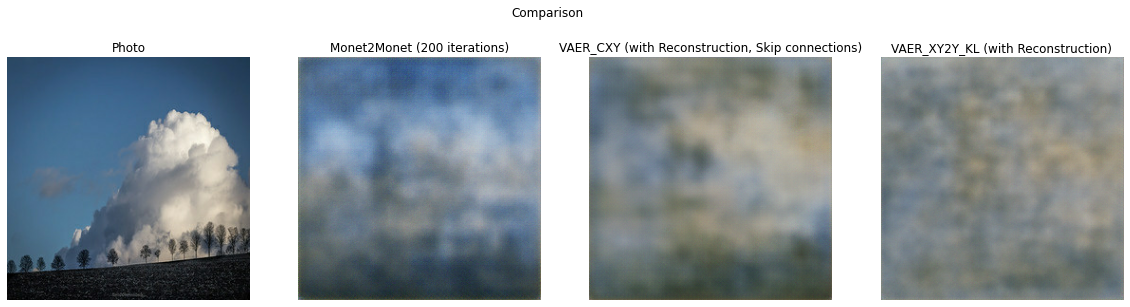

In [ ]:
VAECompare = {"Monet2Monet (200 iterations)":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeM2M_200/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeM2M_200/modelDecoder"],
              "VAER_CXY (with Reconstruction, Skip connections)":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_CXY/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_CXY/modelDecoder"],
              "VAER_XY2Y_KL (with Reconstruction)":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_XY2Y_KL/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_XY2Y_KL/modelDecoder"]}

showResultVAE(photoValid, VAECompare, "Comparison", figsize=(20,5), useSkips=[False, True, False], concats=[False, True, True], sums=[False, False, False])

### Several paintings of our models

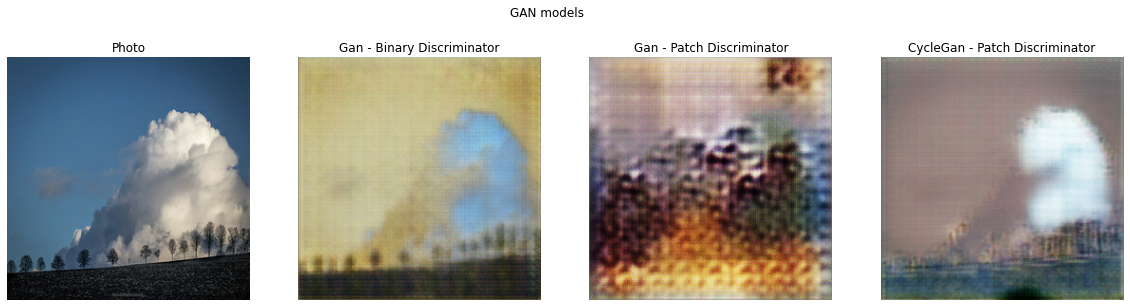

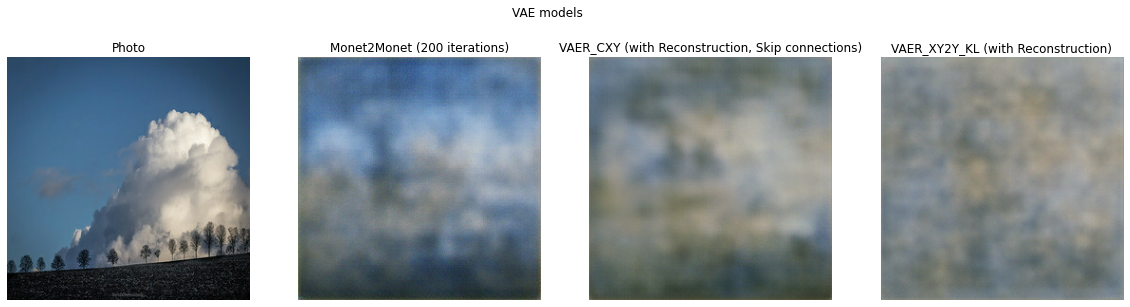

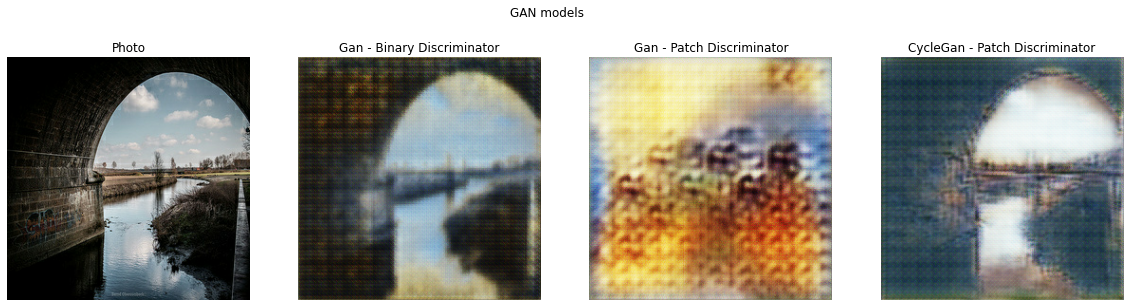

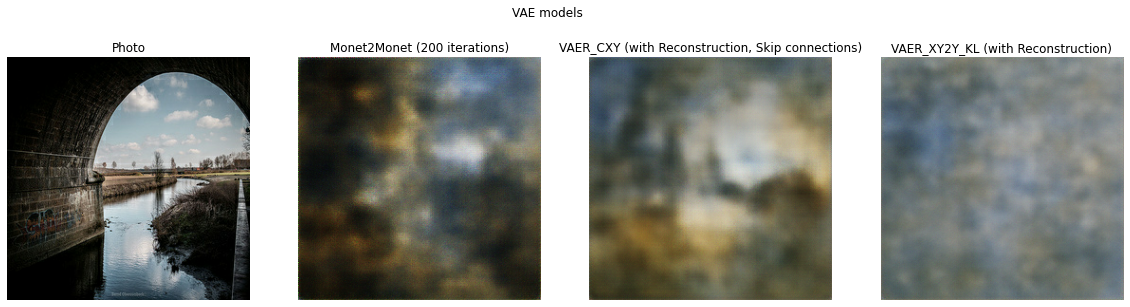

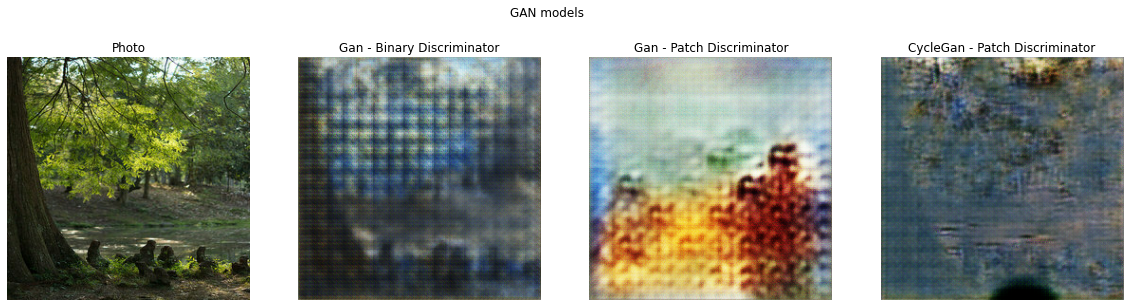

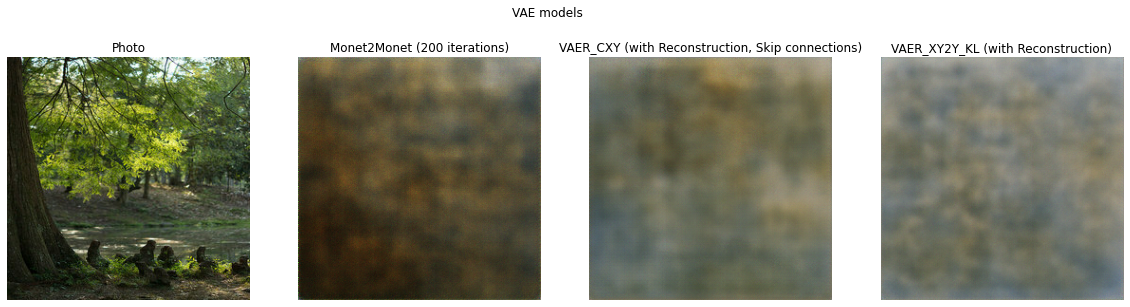

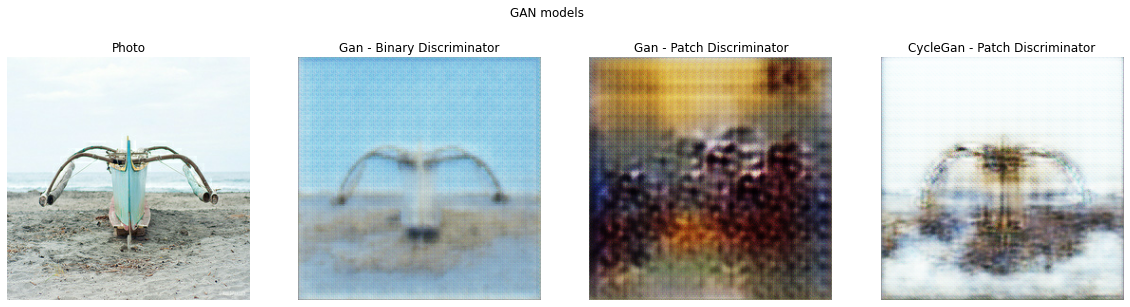

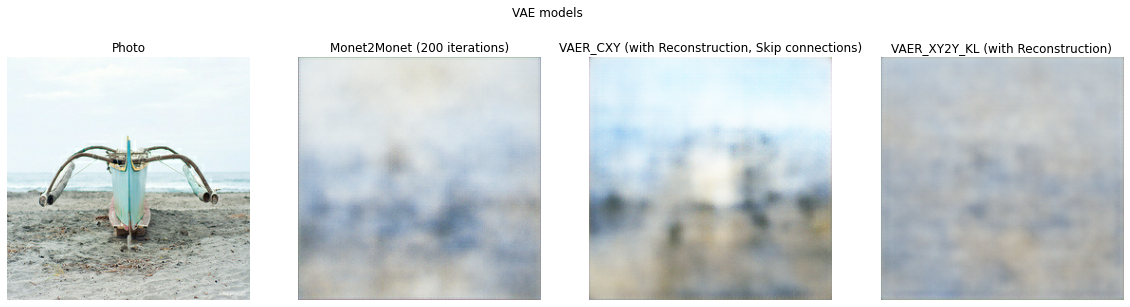

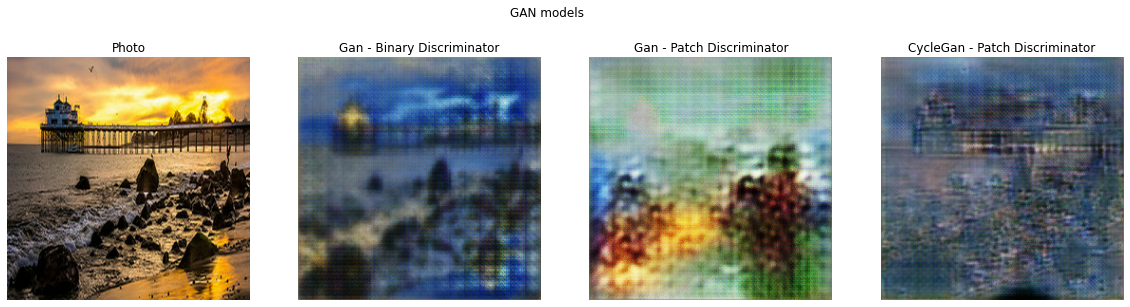

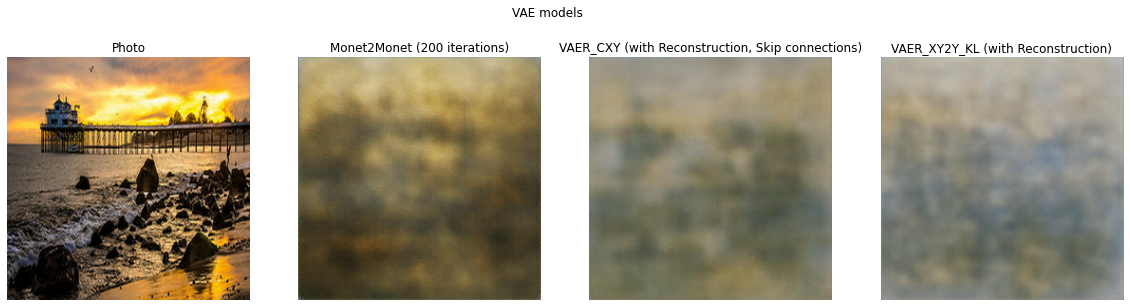

In [ ]:
GANmodels = {"Gan - Binary Discriminator":"/content/drive/MyDrive/Colab Notebooks/GenerativeModels/GAN_Models/simpleGanBinaryDiscriminator/model", 
             "Gan - Patch Discriminator": "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/GAN_Models/ganPatchDiscriminator/model", 
             "CycleGan - Patch Discriminator":"/content/drive/MyDrive/Colab Notebooks/GenerativeModels/GAN_Models/cycleGanPatchDiscriminator/model" }

VAEmodels = {"Monet2Monet (200 iterations)":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeM2M_200/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeM2M_200/modelDecoder"],
              "VAER_CXY (with Reconstruction, Skip connections)":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_CXY/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_CXY/modelDecoder"],
              "VAER_XY2Y_KL (with Reconstruction)":["/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_XY2Y_KL/modelEncoder", "/content/drive/MyDrive/Colab Notebooks/GenerativeModels/VAE_Models/vaeR_XY2Y_KL/modelDecoder"]}

for photo in photoDs.take(5):
  showResultGAN(photo, GANmodels, "GAN models", figsize=(20,5))
  showResultVAE(photo, VAECompare, "VAE models", figsize=(20,5), useSkips=[False, True, False], concats=[False, True, True], sums=[False, False, False])